# Loading modules

If the packages don't load, you'll need to install them using `Pkg.add("module_name")` or from the command line using the `]` to `>pkg` environment.

In [16]:
using NewBioSimulator
# import NewBioSimulator: parse_model

using Combinatorics, SparseArrays, Printf
using Plots

#include("LatticeSimulator-notebook-utils.jl")

## Spatial Predator-Prey Model:

This is for the predator prey model in two dimensions using a hexagonal neighborhood structure.  The rates need to be defined first, passed into the `param` vector, added after each reaction, and listed after the `end` in the `@_def_reactions` macro.  The `@enumerate_with_sclass` takes the skeleton (reactions), a symbol (either `:vonneumann` or `:hexagon`) for the neighborhood structure, then an `Int` for the dimension (1, 2, or 3 for now), and finally the vector of parameters `param`.

Reactions are of two types, pairwise or on-site.  Pairwise reactions look like `A + B --> C + D`, meaning a particle of type `A` interacts with an adjacent particle of type `B`, and each particle changes type to `C` and `D` respectively.  For example, the `F + R --> F + F` predation reaction below denotes a fox `F` eating an adjacent rabbit `R` to produce a new fox.  

On-site reactions have a particle interact with itself only, not with any neighbors.  This looks like `A --> B`.  

In [17]:
using Random

α  = 1.0  # migration rate
β  = 0.02 # rabbit reproduction rate
γ  = 0.02 # predation rate
δ1 = 0.01 # rabbit death rate
δ2 = 0.01 # fox death rate

param = [α, β, γ, δ1, δ2];

skeleton = @def_reactions begin
  R + 0 --> 0 + R, α
  F + 0 --> 0 + F, α
  R + 0 --> R + R, β
  F + R --> F + F, γ
  R --> 0, δ1
  F --> 0, δ2
end α β γ δ1 δ2

model = @enumerate_with_sclass skeleton :hexagon 2 param ;

Here we generate the initial conditions.  `generate_random_2Dpoints` is a function in the `LatticeSimulator-notebook-utils.jl` file that randomly scatters points within the `(xmin, xmax)` and `(ymin, ymax)` range, with some saturation between 0 and 1.  We then randomly assign a type to each point, then feed the whole mess into the `SLattice` function to generate the initial lattice.  Note we need to specify the number of types, and the neighborhood structure again (note this is `hexagonal`, not `hexagon` here... I'll fix this, eventually).  

In [18]:
Random.seed!(5357)

points = generate_random_2Dpoints((0, 9), (0, 9), 0.8)
ptypes = rand(1:2, size(points, 2)) # prey - 1, predator - 2
state = SLattice(points, ptypes, model, number_types=2, nbhood = :hexagonal);

Finally we call the `simulate` function with the `Direct()` tag telling it to use Gillespie's stochastic simulation algorithm.  The `150.0` is the time that the simulation runs for.  This is the same units of time used for the rates.

In [19]:
results = simulate(state, model, Direct(), 150.0, HasRates) ; 

And we plot, using the `hex_config` command in the appendix.  The plotting command is called on the output from the `simulate` function or on the initial condition `state`, the output from the `SLattice` command.

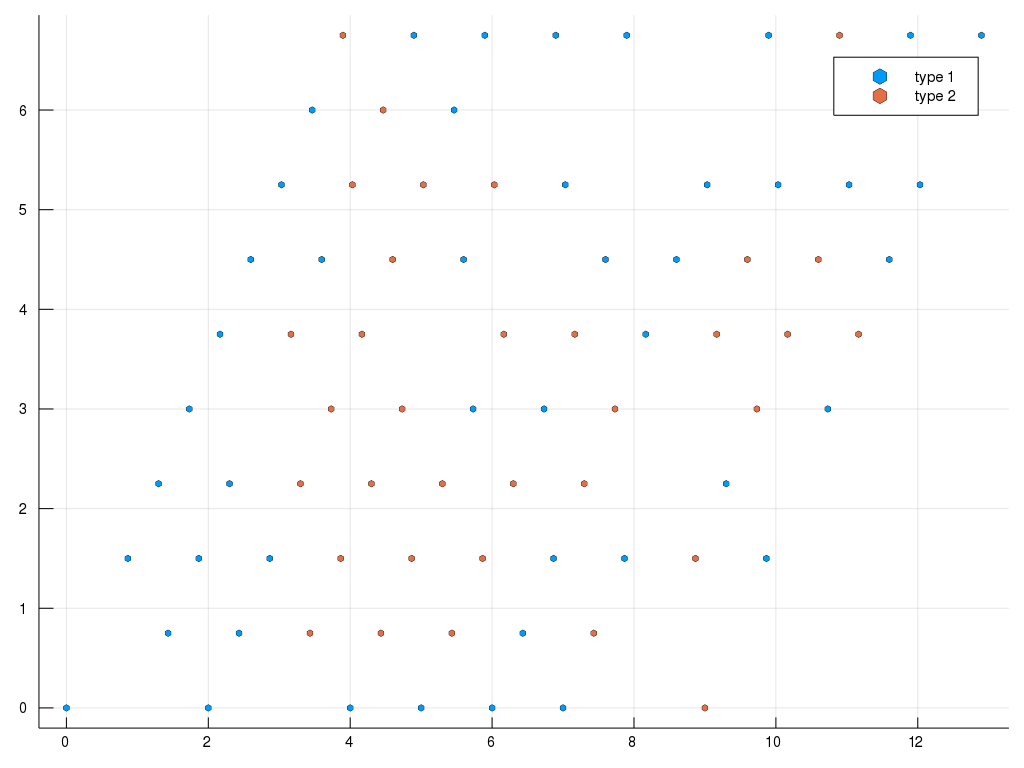

In [20]:
# This is the initial configuration

plot_hex_config(state)

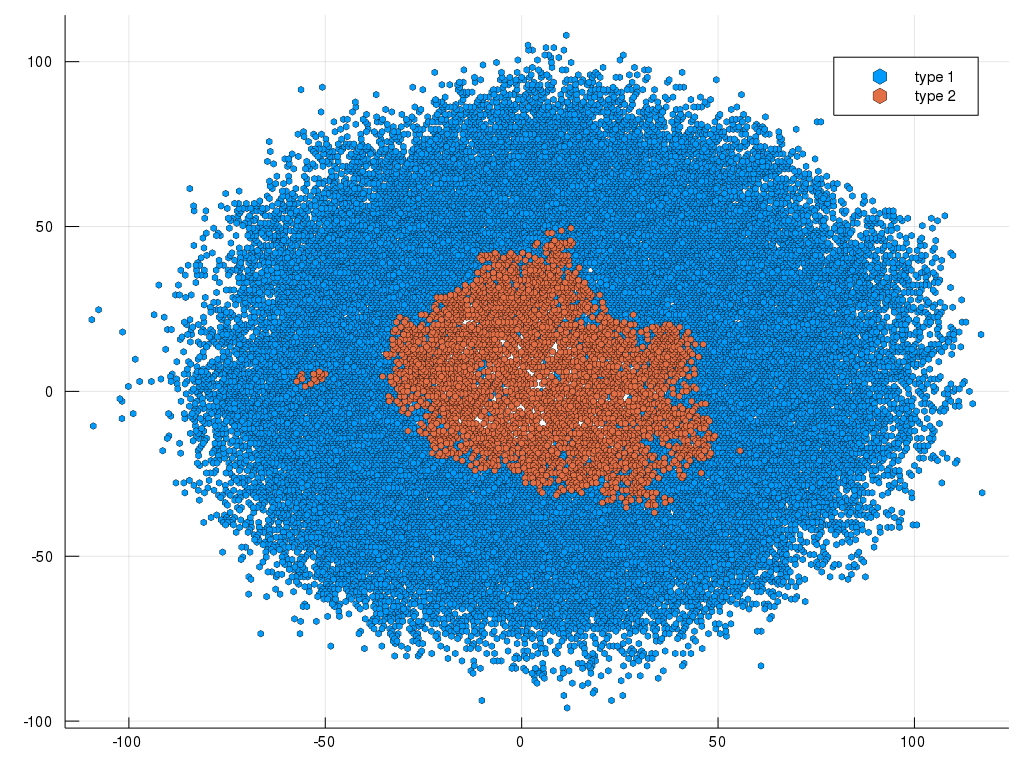

In [21]:
# and this is the final configuration

plot_hex_config(results)

Let us know if you have any questions!

--Tim


## Appendix commands

Also I suspect the hexgrid plotting isn't exactly right... I'll check it and send out a corrected one if necessary.

In [22]:
using Plots
gr(fmt = :png, size = (800, 600), dpi = 128)

##### constants #####

# for reproducibility
const CONFIGURATION_SEED = 5357
const SIMULATION_SEED = 1919

# feel free to modify these values for the notebook
MAX_TIME    = 10.0
MAX_POPSIZE = 10_000
MAX_STEPS   = 100

##### function definitions #####

function generate_random_2Dpoints(xlim, ylim, saturation)
    area = (xlim[2] - xlim[1] + 1) * (ylim[2] - ylim[1] + 1)
    N = Int(ceil(area * saturation))

    list = Tuple{Int,Int}[]

    while length(list) < N
        point = (rand(xlim[1]:xlim[2]), rand(ylim[1]:ylim[2]))
        if point ∉ list
            push!(list, point)
        end
    end

    points = zeros(Int64, 2, length(list))
    for i in eachindex(list)
        points[1, i] = list[i][1]
        points[2, i] = list[i][2]
    end

    return points
end

function plot_config(lattice; show_open = false, title = "", xlab = "", ylab = "", labels = nothing)
    # get number of particle types
    L = lattice.L
    
    # set labels if they were omitted
    if labels == nothing
        labels = ["type $(i)" for i in 1:L]
    end
    
    # retrieve the coordinates of every site tracked by the lattice
    sites = collect(values(lattice.coord2site))

    # retrieve the types of every site
    point_types = Vector{Vector{Tuple{Int,Int}}}(L + 1)

    # extract open sites
    point_types[1] = [tuple(site...) for site in filter(y -> get_ptype(y) == 1, sites)]
    
    # extract remaining sites
    for i in 2:L+1
        point_types[i] = [tuple(site...) for site in filter(y -> get_ptype(y) == i, sites)]
    end
    
    # initialize the plot
    p = plot(xlab = xlab, ylab = ylab, title = title)

    # should we display the open sites?
    if show_open
        scatter!(point_types[1], label = "open", color = :white)
    end
    
    # add the normal types
    for i in 2:L+1
        scatter!(point_types[i], label = labels[i - 1])
    end

    return p 
end



function plot_hex_config(lattice; show_open = false, title = "", xlab = "", ylab = "", labels = nothing)
    # get number of particle types
    L = lattice.L
    
    # set labels if they were omitted
    if labels == nothing
        labels = ["type $(i)" for i in 1:L]
    end
    
    # retrieve the coordinates of every site tracked by the lattice
    sites = collect(values(lattice.coord2site))
    
    new_coords = zeros(Float64, 2, length(sites))

    thingx = sqrt(1 / 4 - 1 / 16)
    thingy = 3 / 4

    for i in 1:length(sites)
        # janky version, modify the sites by shifting the (x,y) coordinates over by the appropriate amount.  Depends on trig.   Done in axial coordinates
        x = sites[i].coord[1]
        y = sites[i].coord[2]
        #x = coordinates(sites[i])[1]
        #y = coordinates(sites[i])[2]

        new_coords[1, i] = x + thingx * y
        new_coords[2, i] = thingy * y

    end

    # initialize the plot
    p = plot(xlab = xlab, ylab = ylab, title = title)

    # should we display the open sites?
   # if show_open
   #     scatter!(point_types[1], label = "open", color = :white)
   # end
    
    # add the normal types
    #for i in 2:L+1
    for i in 2:L+1
            scatter!( [(site.coord[1] + thingx * site.coord[2], thingy * site.coord[2]) for site in filter(y -> y.state.ptype == i, sites)], label = labels[i - 1], 
            markershape = :hexagon, markersize = 2.5, markerstrokewidth = 0.3)
    end

    return p 
end



plot_hex_config (generic function with 1 method)